# Dataset

In [1]:
import sys
sys.path.append('../../datasets/')
from prepare_individuals import prepare, germanBats
import matplotlib.pyplot as plt
import torch
import numpy as np
import tqdm
import pickle

classes = germanBats

In [2]:
patch_len = 44                               # 88 bei 44100, 44 bei 22050 = 250ms ~ 25ms

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../../datasets/prepared.h5", classes, patch_len)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.59it/s]


In [3]:
with open('../call_nocall.indices', 'rb') as file:
    indices, labels = pickle.load(file)
        
    train_indices = indices[0][:len(X_train)]
    test_indices = indices[1][:len(X_test)]
    val_indices = indices[2][:len(X_val)]
    
    X_train = X_train[train_indices]
    X_test = X_test[test_indices]
    X_val = X_val[val_indices]
    
    Y_train = Y_train[train_indices]
    Y_test = Y_test[test_indices]
    Y_val = Y_val[val_indices]

In [4]:
print("Total calls:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total calls: 33868
(19839, 44, 257) (19839,)


# Models

In [5]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            if use_mixup:
                labels = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=len(list(classes))).float()

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Update Weights
            # optimizer.step()

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            if use_mixup:
                running_corrects += (predictions == torch.max(labels, 1)[1]).sum().item()
            else:
                running_corrects += (predictions == labels).sum().item()

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [13]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 1

train_data = TensorDataset(torch.Tensor(np.expand_dims(X_train, axis=1)), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.Tensor(np.expand_dims(X_test, axis=1)), torch.from_numpy(Y_test))
val_data = TensorDataset(torch.Tensor(np.expand_dims(X_val, axis=1)), torch.from_numpy(Y_val))

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [14]:
family_model = torch.jit.load("baseline_families.pt")
rhinolophus_model = torch.jit.load("rhinolophus/baseline_rhinolophus.pt")
myotis_model = torch.jit.load("myotis/2/baseline_myotis.pt")
nyctalus_model = torch.jit.load("nyctalus/1/baseline_nyctalus.pt")
pipistrellus_model = torch.jit.load("pipistrellus/2/baseline_pipistrellus.pt")
eptesicus_model = torch.jit.load("eptesicus/1/baseline_eptesicus.pt")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
    
family_model.to(device)
rhinolophus_model.to(device)
myotis_model.to(device)
nyctalus_model.to(device)
pipistrellus_model.to(device)
eptesicus_model.to(device)
print(device)

cuda:0


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

family_model.eval()
rhinolophus_model.eval()
myotis_model.eval()
nyctalus_model.eval()
pipistrellus_model.eval()
eptesicus_model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    inputs = inputs.cuda()
    
    output = family_model(inputs)
    pred = (torch.max(output, 1)[1]).data.cpu().numpy()[0]
    
    if pred == 0:
        output = rhinolophus_model(inputs)
        pred = (torch.max(output, 1)[1]).data.cpu().numpy()[0]
        if pred == 2:
            continue
    elif pred == 1:
        output = myotis_model(inputs)
        pred = (torch.max(output, 1)[1]).data.cpu().numpy()[0] + 2
        if pred == 9:
            continue
    elif pred == 2:
        output = nyctalus_model(inputs)
        pred = (torch.max(output, 1)[1]).data.cpu().numpy()[0] + 9
        if pred == 11:
            continue
    elif pred == 3:
        output = pipistrellus_model(inputs)
        pred = (torch.max(output, 1)[1]).data.cpu().numpy()[0] + 11
        if pred == 14:
            continue
    elif pred == 4:
        output = eptesicus_model(inputs)
        pred = (torch.max(output, 1)[1]).data.cpu().numpy()[0] + 14
        if pred == 16:
            continue
    elif pred == 5:
        pred = 16
    elif pred == 6:
        pred = 17
    
    Y_pred.append(pred) # Save Prediction

    labels = labels.data.cpu().numpy()
    Y_true.append(labels[0]) # Save Truth

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8828/8828 [02:21<00:00, 62.55it/s]


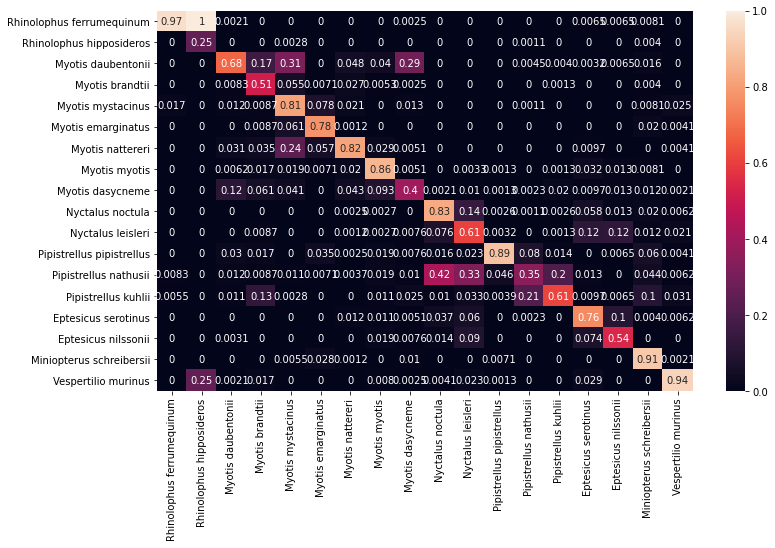

In [23]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('test_cf.png')

In [24]:
from sklearn.metrics import f1_score
corrects = np.equal(Y_pred, Y_true).sum()
print("Test accuracy:", corrects/len(Y_pred))
print("F1-score:", f1_score(Y_true, Y_pred, average=None).mean())

Test accuracy: 0.7296364473078693
F1-score: 0.6733966156031672
